# Análisis Farmacocinético Mono-Compartimental de Sunitinib en Ratones

## Importar bibliotecas necesarias

In [ ]:
from sunitinib_analysis.utils import solve_for_ka, SSR_2C_micro, solve_2C_micro
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random, math

## Cargar y visualizar los datos

In [2]:
df = pd.read_csv('data.csv', index_col=0)
df

,Brain,Plasma,Kidney,Liver
TimePoint,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.08,2.375455,1.253699,7.725515,28.739378
0.25,2.428088,1.883693,17.777037,43.681615
0.50,2.473455,1.635242,22.042997,53.189255
1.00,3.671161,2.028957,35.874868,80.544272
2.00,4.597385,2.850109,66.188478,158.306083
4.00,6.108580,3.384569,64.424283,119.348789
6.00,4.235917,2.608140,53.622046,90.896761
8.00,2.888443,1.869260,39.509340,71.328054


## Selección de columnas relevantes

In [3]:
df_plasma = df[['Plasma']].copy()
df_plasma

,Plasma
TimePoint,
0.00,0.000000
0.08,1.253699
0.25,1.883693
0.50,1.635242
1.00,2.028957
2.00,2.850109
4.00,3.384569
6.00,2.608140
8.00,1.869260


## Determinar el máximo valor de concentración plasmática

In [4]:
max_plasma_idx = df_plasma["Plasma"].idxmax()
max_plasma = df_plasma["Plasma"][max_plasma_idx]
df_filtered = df_plasma.loc[max_plasma_idx:]
df_filtered

,Plasma
TimePoint,
4.0,3.384569
6.0,2.608140
8.0,1.869260
12.0,1.188970


## Cálculo de la constante de eliminación (k_e) y vida media (t½)

Fórmula utilizada:
$$
\ln(C) = \ln(C_0) - k_e \cdot t
$$

In [5]:
t_terminal = df_filtered.index.tolist()
cp_terminal = df_filtered["Plasma"].tolist()
lnCp_terminal = np.log(cp_terminal)
slope, intercept = np.polyfit(t_terminal, lnCp_terminal, 1)

ke = -slope
t_half = np.log(2)/ke

print(f'Constante de eliminación (k_e): {ke:.4f} h^-1')
print(f'Vida media (t1/2): {t_half:.2f} h')
print(f'Intersección con el eje (ln(C0)): {intercept:.4f}')

Constante de eliminación (k_e): 0.1318 h^-1
Vida media (t1/2): 5.26 h
Intersección con el eje (ln(C0)): 1.7327


## Estimación de la constante de absorción (k_a)

Ecuación a resolver:
$$
\ln(x) = k_e(x-1)t_{max}
$$

In [6]:
k_a_estimada = solve_for_ka(ke=ke, tmax=max_plasma_idx)
print(f"k_e={ke:.3f} h^-1, t_max={max_plasma_idx} h, k_a ~ {k_a_estimada:.4f} h^-1")

k_e=0.132 h^-1, t_max=4.0 h, k_a ~ 0.4237 h^-1


## Cálculo del factor de concentración

In [7]:
factor = max_plasma / (math.exp(-ke * max_plasma_idx) - math.exp(-k_a_estimada * max_plasma_idx))
print(f"Factor de concentración: {factor}")

Factor de concentración: 8.323754856250913


## Modelo Monocompartimental con absorción y eliminación de primer orden

Ecuación del modelo:
$$
C(t) = \text{factor} \cdot \left(e^{-k_e \cdot t} - e^{-k_a \cdot t}\right)
$$

In [8]:
def C_1comp_1stOrder_abs_elim(t, factor=factor, ka=k_a_estimada, ke=ke):
    Ct = factor * (np.exp(-ke * t) - np.exp(-ka * t))
    return Ct

## Predicciones y cálculo de errores

In [9]:
df_plasma.loc[:, 'Pred 1C'] = df_plasma.index.to_series().apply(C_1comp_1stOrder_abs_elim)
df_plasma.loc[:,"error"] = df_plasma["Plasma"] - df_plasma["Pred 1C"]
df_plasma.loc[:,"error^2"] = df_plasma["error"]**2
df_plasma

,Plasma,Pred 1C,error,error^2
TimePoint,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.08,1.253699,0.190130,1.063570,1.131181
0.25,1.883693,0.566862,1.316831,1.734044
0.50,1.635242,1.058368,0.576874,0.332784
1.00,2.028957,1.847152,0.181806,0.033053
2.00,2.850109,2.828155,0.021954,0.000482
4.00,3.384569,3.384569,0.000000,0.000000
6.00,2.608140,3.119462,-0.511322,0.261450
8.00,1.869260,2.619034,-0.749773,0.562160


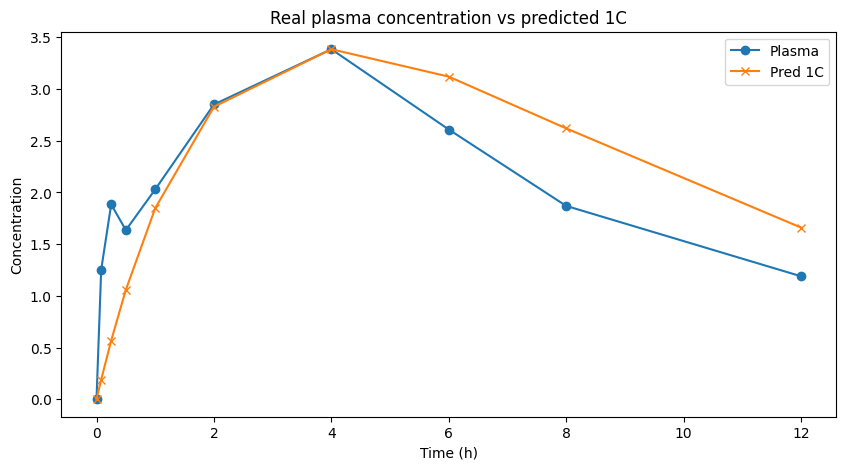

In [10]:
plasma_values = df_plasma["Plasma"].tolist()
pred_values = df_plasma["Pred 1C"].tolist()

plt.figure(figsize=(10, 5))
plt.plot(df_plasma.index, plasma_values, label='Plasma', marker='o')
plt.plot(df_plasma.index, pred_values, label='Pred 1C', marker='x')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Real plasma concentration vs predicted 1C')
plt.legend()
plt.show()

## Cálculo de SSR (Suma de cuadrados residuales)

In [11]:
ssr_1c = df_plasma["error^2"].sum()
print(f"SSR: {ssr_1c:.4f}")

SSR: 4.2769


## Cálculo del criterio de información de Akaike (AIC)

Fórmula utilizada:
$$
AIC = n \cdot \ln\left(\frac{SSR}{n}\right) + 2p
$$

Donde:
- \( n \) = número de observaciones
- \( p \) = número de parámetros (k_a, k_e, factor)

In [12]:
p = 3
n = len(df_plasma)-1

aic_1c = n*np.log(ssr_1c/n) + 2*p
print(f"AIC: {aic_1c:.4f}")

AIC: -0.6959


## Resumen de resultados

- **k_e** (constante de eliminación): 0.132
- **k_a** (constante de absorción): 0.4237
- **Factor de concentración**: 8.32
- **SSR**: 4.2769
- **AIC**: -0.6959

Esto permite evaluar el efecto del ketoconazol sobre la distribución de sunitinib en tejidos de ratones mediante comparación cuantitativa del modelo farmacocinético ajustado.

# Análisis Farmacocinético Bi-Compartimental de Sunitinib en Ratones

## Selección de columnas relevantes

In [13]:
df_plasma

,Plasma,Pred 1C,error,error^2
TimePoint,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.08,1.253699,0.190130,1.063570,1.131181
0.25,1.883693,0.566862,1.316831,1.734044
0.50,1.635242,1.058368,0.576874,0.332784
1.00,2.028957,1.847152,0.181806,0.033053
2.00,2.850109,2.828155,0.021954,0.000482
4.00,3.384569,3.384569,0.000000,0.000000
6.00,2.608140,3.119462,-0.511322,0.261450
8.00,1.869260,2.619034,-0.749773,0.562160


## Datos observados

In [14]:
t_obs = df_plasma.index.tolist()[1:]
cp_obs = df_plasma["Plasma"].tolist()[1:]
n = len(t_obs)

## Modelo Bicompartimental (microconstantes)
Las ecuaciones diferenciales del modelo bicompartimental son:

$$
\frac{dX_g}{dt} = -k_a \cdot X_g
$$
$$
\frac{dX_c}{dt} = k_a X_g - k_{10} X_c - k_{12} X_c + k_{21} X_p
$$
$$
\frac{dX_p}{dt} = k_{12} X_c - k_{21} X_p
$$

La concentración plasmática es:

$$
C_p(t) = \frac{X_c(t)}{V_c}
$$

## Función de integración numérica (Euler)

```python
def solve_2C_micro(ka, k10, k12, k21, Vc, times, dt=0.02):
    Xg, Xc, Xp = 1.0, 0.0, 0.0
    t_current = 0.0
    results, idx_times = [], 0
    max_time = times[-1]

    while t_current <= max_time + 1e-9:
        while idx_times < len(times) and t_current >= times[idx_times]-1e-9:
            Cp = Xc / Vc
            results.append(Cp)
            idx_times += 1
            if idx_times >= len(times):
                break

        dXg = -ka * Xg
        dXc = ka * Xg - k10 * Xc - k12 * Xc + k21 * Xp
        dXp = k12 * Xc - k21 * Xp

        Xg += dXg * dt
        Xc += dXc * dt
        Xp += dXp * dt
        t_current += dt

    return np.array(results)
```

## Función para calcular SSR

```python
def SSR_2C_micro(params, t_obs, cp_obs):
    ka, k10, k12, k21, Vc = params
    if any(p <= 0 for p in params):
        return 1e12

    cp_pred = solve_2C_micro(ka, k10, k12, k21, Vc, t_obs)
    if np.any(cp_pred < 0) or len(cp_pred) != len(cp_obs):
        return 1e12

    ssr = np.sum((cp_obs - cp_pred)**2)
    return ssr
```

## Optimización de parámetros por búsqueda aleatoria

In [15]:
best_params, ssr_2c = None, 1e15
random.seed(0)

ssrs = []
for _ in range(60000):
    ka  = 10**random.uniform(-2, 0.5)
    k10 = 10**random.uniform(-2, 0.3)
    k12 = 10**random.uniform(-2, 0.5)
    k21 = 10**random.uniform(-2, 0.5)
    Vc  = 10**random.uniform(-1, 1.3)
    params = (ka, k10, k12, k21, Vc)
    ssr = SSR_2C_micro(params, t_obs, cp_obs)
    ssrs.append(ssr)

    if ssr < ssr_2c:
        ssr_2c, best_params = ssr, params

print("Mejor SSR encontrado:", ssr_2c)
print("Parámetros (ka, k10, k12, k21, Vc) =", best_params)

Mejor SSR encontrado: 2.2116222231494587
Parámetros (ka, k10, k12, k21, Vc) = (0.6466797633846326, 0.1573120040466821, 0.4492922916273097, 0.9008250884827278, 0.15134608984026762)


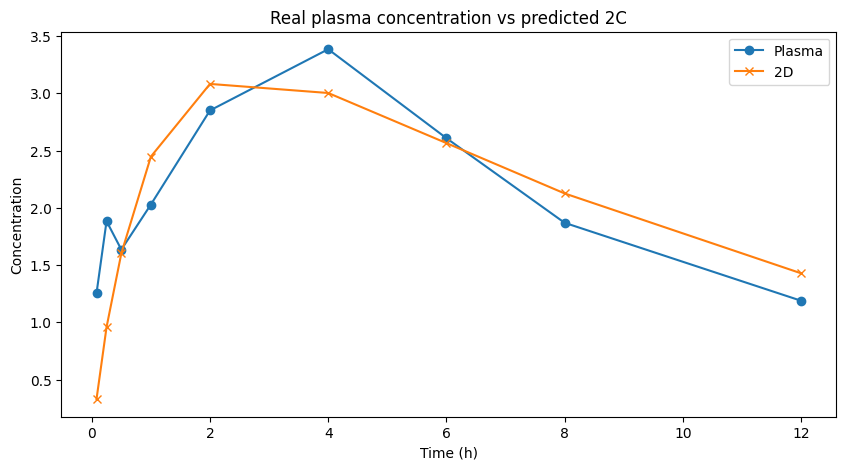

In [16]:
ka, k10, k12, k21, Vc = best_params
cp_pred = solve_2C_micro(ka, k10, k12, k21, Vc, t_obs)
plt.figure(figsize=(10, 5))
plt.plot(t_obs, cp_obs, label='Plasma', marker='o')
plt.plot(t_obs, cp_pred, label='2D', marker='x')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Real plasma concentration vs predicted 2C')
plt.legend()
plt.show()

## Criterio de información de Akaike (AIC)

La fórmula del AIC es:

$$
AIC = n \cdot \ln\left(\frac{SSR}{n}\right) + 2p
$$

donde \( n \) es el número de observaciones y \( p \) es el número de parámetros libres (5 en este caso).

In [17]:
p = 5
aic_2c = n * math.log(ssr_2c / n) + 2 * p
print("AIC (modelo bicompartimental) =", aic_2c)

AIC (modelo bicompartimental) = -2.631484641105997


## Resumen de resultados

- **Parámetros óptimos**: (ka, k10, k12, k21, Vc) = (0.647, 0.157, 0.449, 0.9, 0.151)
- **SSR**: 2.21
- **AIC**: -2.631

Esto permite evaluar si el modelo bicompartimental mejora respecto al modelo monocompartimental para describir la farmacocinética del sunitinib en plasma.

In [18]:
results_df = pd.DataFrame({"Mono-Compartimental": [ssr_1c, aic_1c], 
                        "Bi-Compartimental": [ssr_2c, aic_2c]}, 
                        index=['SSR', 'AIC']
)
results_df = results_df.T
results_df.index.name = 'Modelo'
results_df

,SSR,AIC
Modelo,,
Mono-Compartimental,4.276915,-0.695933
Bi-Compartimental,2.211622,-2.631485


# Conclusiones del Análisis

El análisis comparativo entre los modelos farmacocinéticos indica que el modelo **bi-compartimental** es más adecuado que el **mono-compartimental**, debido a que presenta un valor de **SSR más bajo (2.21 frente a 4.28)**, lo que refleja una mejor adaptación a los datos observados. Asimismo, el **AIC es significativamente inferior (-2.63 frente a -0.70)**, reforzando que el modelo bi-compartimental ofrece un mejor balance entre ajuste y simplicidad. Por tanto, se recomienda el uso del modelo bi-compartimental para describir estos datos.